# Coursework 2 - Texas Bridges: Predicting Bridge Condition
### Statistics for AI and Data Science
---

## Introduction

This analysis has been performed on behalf of the **Texas Department of Transportation (TxDOT)**. The aim is to investigate how bridge characteristics influence overall structural condition across Texas.

The Department's management, which is represented by a specialist in bridge materials and corrosion, has requested an evidence-based  analysis using regression modelling to understand:

1. **Which of the proposed predictor variables most strongly influence current bridge condition.**

2. **How well these predictors collectively explain variation in bridge condition.**

The analysis has been conducted with utilisation of data on *bridge construction year, daily average use, truck percentage, material and design type*. In addition, we have used three component-level condition ratings. Our data has been taken from the source file of **'tx19_bridges_sample.csv'.** 

This notebook report is structured as follows:

- **Part 1 - Data Preparation:** Cleaning, feature derivation, category simplification and distribution checks.

- **Part 2 - Exploratory Analysis:** Examining relationships between condition and predictor variables.

- **Part 3 - Regression Modelling:** Building and interpreting a linear regression model.

All code has been executed in order without errors and we have included our analysis and interpretation as the code progresses. 

---

## Part 1 - Data Preparation (Exploratory Load)

<u>**Objective**

Prior to any cleaning or modelling, we first must load the raw Texas bridges to:

a) Confirm the structure, columns and row count.

b) Preview the data that we are dealing with.

c) Inspect the *qualitative* condition variables so we can define an **ordered scale** correctly later on.

<u>**Actions Performed**
- Read the raw CSV (**'tx19_bridges_sample.csv'**) for exploration.

- Print the dataset shape and preview the first few rows.

- List the unique labels for the three inspection ratings: *'Deck_rating', 'Superstr_rating',* and *'Substr_rating'.*

> Note: This is an **exploratory read**. We will reload the data below with appropriate data types (including an **ordered categorical** type for the ratings) and then derive a single target variable for modelling.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

tx_df = pd.read_csv('tx19_bridges_sample.csv')

print('Shape', tx_df.shape)
tx_df.head()

Shape (34293, 25)


,Structure_id,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
0,000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
1,000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
2,000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
3,000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
4,000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200


In [3]:
columns = ['Deck_rating', 'Superstr_rating', 'Substr_rating']

for c in columns:
    print(c, ':', tx_df[c].unique())

Deck_rating : ['Good' 'Very Good' 'Fair' 'Satisfactory' 'Excellent' 'Failed' 'Poor' nan
 'Failing' 'Serious' 'Critical']
Superstr_rating : ['Very Good' 'Good' 'Fair' 'Satisfactory' 'Failed' 'Poor' 'Excellent'
 'Serious' 'Failing' nan 'Critical']
Substr_rating : ['Very Good' 'Poor' 'Satisfactory' 'Fair' 'Good' 'Serious' 'Failed'
 'Critical' 'Excellent' 'Failing']


### Findings From The Exploratory Read

- The file contains approximately 34k rows and 25 columns, covering different bridge attributes such as year, design, material, length and etc. As well as the three component ratings.

- The three rating columns use the expected inspection scale which runs from **'Failed/Failing/Critical/Serious... up to ... Very Good/Excellent'**.

- There are a small number of entries that are missing (e.g. 'NaN'/'N/A') and will be handled explicitly.

- This confirms we can safely define a single ordered categorical **rating type** with the sequence:

*Failed < Failing < Critical < Serious < Poor < Fair < Satisfactory < Good < Very Good < Excellent < N/A*

<u>**Next Steps**

We will reload the dataset with these types implemented, convert the ordered categories to numeric codes and then create the overall condition target (`Condition_sum`) by combining the three component ratings.

---

### 1.1) Defining Ordered Categorical Variables and Reloading The Dataset

This next step ensures that each column in the datatset has an appropriate data type and that the bridge condition ratings are **treated as ordered categorical variables**. This is essential because the inspection categories represent a ranked scale of performance rather than unrelated labels.

<u>**Actions Performed**
- A custom ordered `CategoricalDtype` was defined for the three component condition variables: *`Deck_rating`, `Superstr_rating`* and *`Substr_rating`*.
These follow the inspection order from *'Failed' (worst)* to *'Excellent' (best)*.

- A `types_dict` dictionary was created to specify suitable data types for each variable: categorical for qualitative variables (e.g. `Material`, `Design`, `Status` and etc) and string for identifiers.

- The dataset was reloaded with these types implemented and the `Structure_id` was used as the index.

- Any rows which were missing any of the three rating fields were removed to ensure complete data for analysis.

> Reloading the data with types defined at the read stage improves efficiency, ensures consistency and prevents any downstream errors when numerical operations are conducted.

In [4]:
rating_type = pd.CategoricalDtype(
    categories = ['Failed', 'Failing', 'Critical', 'Serious', 
                  'Poor', 'Fair', 'Satisfactory', 'Good', 
                  'Very Good', 'Excellent', 'N/A'], ordered = True)

types_dict = {'Structure_id': 'str', 'District': 'category', 'Toll': 'category',
              'Maintainer': 'category', 'Urban': 'category', 'Status': 'category',
              'Historic': 'category', 'Service_under': 'category', 'Material': 'category',
              'Design': 'category', 'Deck_rating': rating_type, 'Superstr_rating': rating_type,
              'Substr_rating': rating_type, 'Scour_rating': 'category'}

tx_df = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')

tx_df = tx_df.dropna(subset = ['Deck_rating', 'Superstr_rating', 'Substr_rating'])

print(tx_df.shape)
tx_df.head()

(34286, 24)


,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200


### Dataset After Assignment of Type and Cleansing

**After reloading:**
- The dataset now has **34,286 bridges** and **24 columns**, this indicates to us that a small number of incomplete rows have been removed.

- The `Structure_id` column is now the index, this allows for subsequent lookups cleaner.

- Each inspection rating column (*`Deck_rating`, `Superstr_rating`, `Substr_rating`*) is now an **ordered categorical variable**.

At this stage, the dataset is clean, structured and ready for following actions to be performed to produce a numeric bridge **Condition Score**, which will be used as the dependent variable in the regression model. 

---

### 1.2) Deriving a Composite Bridge Condition Score

We wish to express the overall bridge condition as a **single continuous variable** and we have done this by taking the sum of the three main ratings:
- Deck rating
- Superstructure rating
- Substructure rating

Each of these ratings are ordinal, ranging from `Failed` to `Excellent`. In order to allow for our statistical modelling to be performed later (Linear Regression), these categories are converted into **integer codes** representing their order of condition.

**Actions Performed**
1) Replace `N/A` with `NaN` and drop any rows still missing one of the condition ratings.

2) Convert the three categorical condition columns into numeric form using *`.cat.codes`*.

3) Create a new variable called **`Condition_sum`** by summing the three component scores. This provides a single measure of total bridge condition, with higher values representing better overall condition.

> The resulting continuous variable *Condition_sum* will act as the **dependent variable** (Y) in our regression model later on. 

In [5]:
for c in columns:
    tx_df.loc[tx_df[c] == 'N/A', c] = pd.NA

tx_df = tx_df.dropna(subset = columns)

for c in columns:
    tx_df[c + '_score'] = tx_df[c].cat.codes

tx_df['Condition_sum'] = tx_df[[c + '_score' for c in columns]].sum(axis = 1)

print(tx_df['Condition_sum'].describe())       

count    34286.000000
mean        20.300239
std          2.004642
min          0.000000
25%         19.000000
50%         21.000000
75%         22.000000
max         27.000000
Name: Condition_sum, dtype: float64


### Interpreting The Derived Condition Score

The summary statistics show that:
- The average total condition score is around **20.3** out of a maximum of **27**. This implies that the majority of bridges are in relatively good condition.

- The minimum value of **0** corresponds to bridges that are in very poor or failed states, whilst the lower to upper quartile (19 and 22 respectively) indicates a concentration of bridges in the 'Good - Very Good' range.

This transformation successfully converts ordinal inspection ratings into a **continuous quantitative measure** that is suitable for correlation and regression analysis which will be conducted later in **Part 2** and **Part 3** of this report.

---

### 1.3) Reviewing Original Design and Material Categories

Before we simplify the dataset, it is important that we understand the distribution of the original categorical variables - **Design** and **Material**. These describe the structural design type and the primary construction material that has been used for each bridge.

By examining the frequency counts for both variables, we are able to identify which categories are the most common and which only occur rarely. This step ensures that the simplification that is performed later will be based on evidence-based decisions by only grouping small or infrequent categories.

In [6]:
print('Original Design value counts:')
print(tx_df['Design'].value_counts())

print('\nOriginal Material value counts:')
print(tx_df['Material'].value_counts())

Original Design value counts:
Design
Beam          28324
Slab           4340
Other          1240
Arch            159
Truss           137
Frame            68
Movable          13
Suspension        5
Name: count, dtype: int64

Original Material value counts:
Material
Concrete    27123
Steel        6637
Timber        465
Other          48
Masonry        13
Name: count, dtype: int64


***From the results we can see that:***
- The **Beam** design is clearly the most common, which is then followed by **Slab**. We then have types such as **Arch**, **Truss** and other specialised designs that appear far less frequently.

- For materials, **Concrete** and **Steel** make up the majority of the dataset, with **Timber** and a few 'Other' or less common material representing just a small proportion of of the total bridges.

This analysis confirms that there are a few major categories that account for the great majority of observations. Hence, this supports the need for simplification before we perform our regression modelling.

---

### 1.4) Simplifying the Design and Material Categories

Following the initial review we conducted, we simplified the categorical variables to reduce noise and improve interpretability.

We performed our simplification by the following process:
- Keeping the **five most frequent design types** *(Beam, Slab, Arch, Truss and Other)*.

    *-> The top five account for over 99% of all bridges, ensuring that no                structural type is excluded while still reducing sparse categories.*

- Retaining the **three most frequent materials** *(Concrete, Steel and Timber)*.

    *-> These cover more than 98% of all bridges and the remaining rare materials         (such as Masonry) contribute too few observations to analyse reliably.*

- All remaining minor categories have then been merged under **`Other`** to ensure a manageable number of levels for analysis and regression.

In [7]:
design_clean = tx_df['Design'].value_counts().nlargest(5).index

material_clean = tx_df['Material'].value_counts().nlargest(3).index

tx_df['Design_simplified'] = tx_df['Design'].apply(lambda x: x if x in design_clean else 'Other')
tx_df['Material_simplified'] = tx_df['Material'].apply(lambda x: x if x in material_clean else 'Other')

print('\nSimplified Design value counts:')
print(tx_df['Design_simplified'].value_counts())

print('\nSimplified Material value counts:')
print(tx_df['Material_simplified'].value_counts())


Simplified Design value counts:
Design_simplified
Beam     28324
Slab      4340
Other     1326
Arch       159
Truss      137
Name: count, dtype: int64

Simplified Material value counts:
Material_simplified
Concrete    27123
Steel        6637
Timber        465
Other          61
Name: count, dtype: int64


After simplification, the new variable **`Design_simplified`** and **`Material_simplified`** were created.

These revised categories have retained the most meaningful distinctions across bridge types and materials while avoiding sparsity issues caused by very small groups. Choosing five design groups and three material groups strikes a balance between **representing structural diversity** and **maintaining statistical robustness**. Hence, this makes the dataset more suitable for regression modelling and easier to interpret when comparing structural and material influences on bridge condition.

---

### 1.5) Reviewing Bridge Construction Years

The variable **'Year'** represents the year each bridge was built.
Prior to any further data manipulation, it is crucial to explore the distribution of construction years to identify any potential anomalies and to determine whether older bridges should be excluded from the analysis.

In [8]:
print(tx_df['Year'].unique())



[2005 2012 1950 2004 2017 1934 2018 2016 1938 1958 1983 2008 1954 1962
 1948 1986 1990 1949 1959 1955 1956 1996 2007 1968 2010 1960 1970 2001
 2006 1945 1997 1999 2013 2002 2003 1992 1921 1995 1933 1931 1924 2000
 1994 1998 1984 1947 1969 1943 1985 1987 1940 1991 1982 1993 1966 1980
 1964 1979 1989 1988 1981 2009 1965 1971 2015 2011 1973 1942 1936 1976
 1957 1963 1975 1930 1961 2014 1952 1967 1935 1926 1925 1977 1974 1922
 1937 1953 1941 1951 1946 1978 1972 1920 1939 1928 1923 1906 1944 1927
 1929 1911 1932 1914 1919 1913 1900 1904 1910 1918 1901 1917 1915 1909
 1916 1912 1905 1908 2019]


### Filtering Out Older Bridges

After reviewing the different years in the dataset, several bridges can be seen to have construction dates as old as the early 1900s.
To ensure that the analysis focuses on bridges built under more relatively modern and consistent engineering practices, bridges constructed **prior to 1950** were excluded from the dataset.

This threshold was chosen because bridges that were built before 1950 are likely to:

- Have been constructed using outdated materials or methods.

- Have undergone numerous reconstructions or repairs, which will distort the original age-condition relationship.

- Represent a very small proportion of the total dataset (less than 10%, when comparing the shape of the filtered dataset below to the original dataset at the start of this report), meaning the removal of these bridges does not significantly impact the sample size.

> Filtering in this way leaves a cleaner and more representative dataset for the analysis we will perform later.

In [9]:
tx_df = tx_df[tx_df['Year'] >= 1950]

print(tx_df.shape)

(30908, 30)


Although the dataset includes a **`Historic`** column, this field was **not used for filtering** because it may reflect administrative designations rather than actual structural age or condition.  
Some bridges classified as historic may have been fully refurbished and remain in excellent condition, while others may not be marked historic despite being very old.  
Filtering by construction year instead provides a more objective and consistent basis for exclusion.

---

### 1.6) Distribution of Bridge Construction Years

To visualise the updated dataset, a histogram of the bridge construction years was plotted.
This allows for us to see the trends in bridge construction over time, this will include periods of higher infrastructure development, and it confirms that the filtering of pre-1950 bridges has been applied correctly.

The histogram shows that the majority of bridges were constructed between the **1960s and 2000s**, which reflects that there was a large-scale expansion of the road networks during these decades.

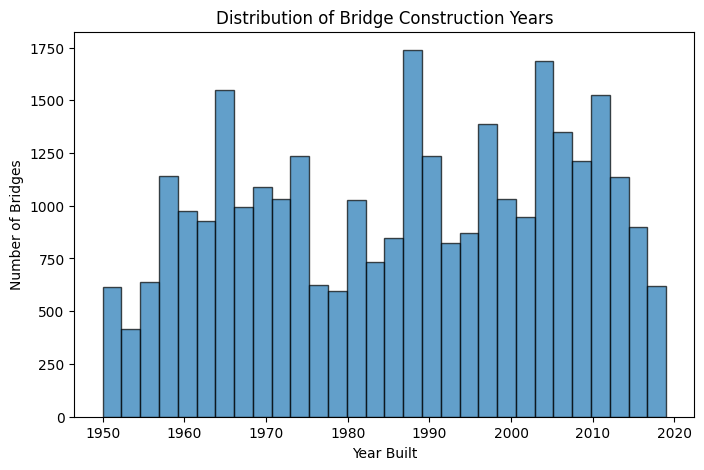

In [11]:
plt.figure(figsize = (8, 5))
plt.hist(tx_df['Year'], bins = 30, edgecolor = 'black', alpha = 0.7)
plt.title('Distribution of Bridge Construction Years')
plt.xlabel('Year Built')
plt.ylabel('Number of Bridges')

plt.show()

### Exploring the Distribution of Bridge Condition Scores

Next, the distribution of the derived variable **`Condition_sum`** was examined using a histogram.  
This helps to assess whether the bridge condition scores are approximately continuous and suitable for later regression analysis.

The histogram indicates that most bridges have relatively high condition scores, suggesting that the majority of bridges are in good or satisfactory condition.  
Only a small number of bridges fall in the lower tail of the distribution, which likely represent structures in poorer or failed condition.


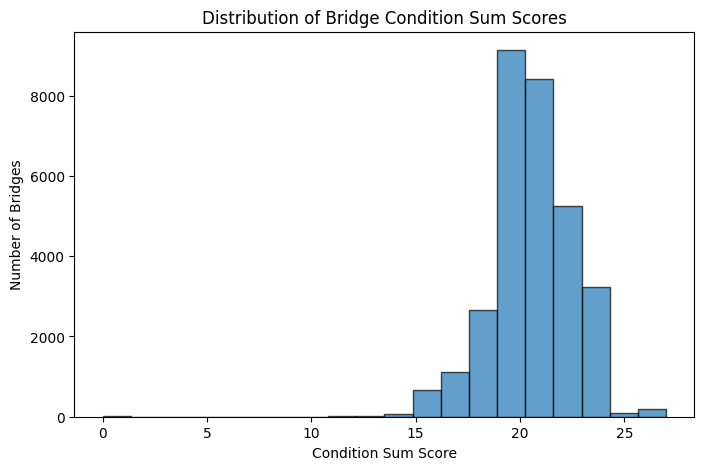

In [12]:
plt.figure(figsize = (8, 5))
plt.hist(tx_df['Condition_sum'], bins = 20, edgecolor = 'black', alpha = 0.7)
plt.title('Distribution of Bridge Condition Sum Scores')
plt.xlabel('Condition Sum Score')
plt.ylabel('Number of Bridges')

plt.show()

### Boxplot of Bridge Condition Scores

A boxplot was produced to further explore the spread and potential outliers in the `Condition_sum` variable.  
The plot shows a moderately concentrated distribution with several low-scoring outliers, representing bridges in significantly worse condition.
Although several outliers are visible, they were retained in the dataset for this exploratory stage, as their influence was assessed later through residual analysis in Part 3 of this report.

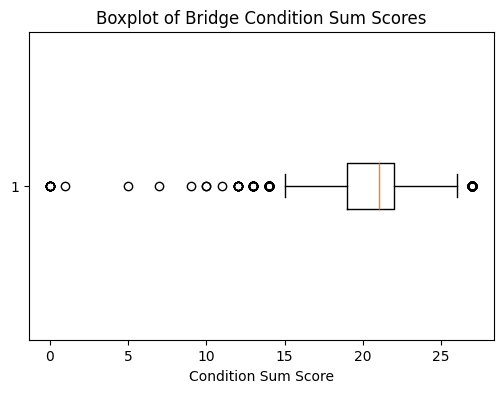

In [13]:
plt.figure(figsize = (6, 4))
plt.boxplot(tx_df['Condition_sum'], vert = False)
plt.title('Boxplot of Bridge Condition Sum Scores')
plt.xlabel('Condition Sum Score')

plt.show()

---
### 1.7) Deriving Bridge Age

To facilitate further analysis, a new variable **`Age`** was calculated by subtracting the construction year from the current year (2025).  
This variable represents the approximate age of each bridge in years and provides a continuous measure that can be used in correlation and regression analysis.

The resulting summary statistics indicate that:
- The average bridge age is around **38 years**.  
- The youngest bridge is about **6 years old**, while the oldest (within the filtered dataset) is **75 years**.  

This confirms that the dataset now covers a broad yet realistic range of bridge ages suitable for modelling the relationship between **age and condition** in Part 2.


In [16]:
tx_df['Age'] = 2025 - tx_df['Year']

print(tx_df['Age'].describe())
print(tx_df['Age'].min(), tx_df['Age'].max())

count    30908.000000
mean        38.473211
std         19.145511
min          6.000000
25%         21.000000
50%         37.000000
75%         56.000000
max         75.000000
Name: Age, dtype: float64
6 75


---
### 1.8) Final Data Validation and Summary Checks

After completing the data cleaning and transformation steps, a final validation was performed to confirm that all key variables were correctly formatted and contained no missing values.  
This included checking:
- **Variable types**, to ensure numerical and categorical fields were properly defined.
- **Missing values**, to verify that earlier filtering and data cleaning steps were successful.
- **Category values**, to confirm that the simplification of the `Material` and `Design` columns was correctly implemented.

These checks are essential to confirm the dataset is consistent, complete, and ready for further statistical analysis in Part 2.


In [17]:
print('Summary of variable types:')
print(tx_df[['Age', 'AverageDaily', 'Trucks_percent', 'Material_simplified',
             'Design_simplified', 'Condition_sum']].dtypes)

print('\nMissing values in key variables:')
print(tx_df[['Age', 'AverageDaily', 'Trucks_percent', 'Material_simplified',
             'Design_simplified', 'Condition_sum']].isna().sum())

print('\nUnique Material_simplified values:', tx_df['Material_simplified'].unique())
print('Unique Design_simplified values:', tx_df['Design_simplified'].unique())

Summary of variable types:
Age                      int64
AverageDaily             int64
Trucks_percent         float64
Material_simplified     object
Design_simplified       object
Condition_sum            int64
dtype: object

Missing values in key variables:
Age                    0
AverageDaily           0
Trucks_percent         0
Material_simplified    0
Design_simplified      0
Condition_sum          0
dtype: int64

Unique Material_simplified values: ['Concrete' 'Timber' 'Steel' 'Other']
Unique Design_simplified values: ['Slab' 'Beam' 'Other' 'Truss' 'Arch']


---
### Summary and Conclusion of Part 1 – Data Preparation

All data preparation steps have now been completed.  
The dataset has been successfully cleaned, simplified, and validated, ensuring it is suitable for regression analysis.  
Key outcomes from this stage include:

- **Creation of a continuous condition variable** (`Condition_sum`) by combining the three structural ratings.  
- **Simplification of categorical variables** (`Design_simplified` and `Material_simplified`) to reduce category sparsity while retaining interpretive clarity.  
- **Filtering of older bridges (pre-1950)** to remove potentially incomparable or outlier structures.  
- **Verification of data integrity**, confirming that no missing values remain in critical fields and all variables are correctly typed.

The resulting dataset provides a robust foundation for the next stage - exploring statistical relationships between bridge condition, age, design, material, and traffic variables in **Part 2: Regression Analysis**.

---

## Part 2 - Exploratory Analysis

<u>**Objective**

Following data preparation and cleaning in Part 1, the aim of this section is to **explore relationships** between the predictor variables and the target variable (`Condition_sum`).
The objective is to identify trends, correlations and potential drivers of bridge condition that can later influence the regression model that we will be using.

Specifically, this analysis seeks to:  
- Understand how bridge **age**, **design**, **material**, and **traffic levels** relate to overall structural condition.

- Assess whether the predictor variables are interrelated, which could have implications for multicollinearity in the regression phase.


- Provide the Texas Department of Transportation with clear, evidence-based preliminary insights before formal modelling.  

<u>**Actions Performed**  

- Begin by **examining the distribution of bridge ages**, since bridge age is expected to be one of the most influential predictors of condition.

- Compute and interpret the **correlation coefficient** between bridge age and overall condition to quantify this relationship.

- Use a **scatter plot** to visually represent the association and detect potential non-linear trends or outliers.  

> **Note:**  
> The “Distribution of Bridge Ages” appears at the start of this section to set the context for the analysis.  
> While `Age` was already derived during **Part 1 - Data Preparation**, its exploration here belongs to the *exploratory analysis phase* because we now interpret it in relation to the dependent variable (`Condition_sum`).  
> This approach ensures a logical transition from cleaning to insight discovery.

### 2.1) Distribution of Bridge Ages  

The histogram below displays the distribution of bridge ages.  
The data show a wide range of ages, with most bridges constructed between the 1960s and 1990s.  
This suggests that a large proportion of bridges in Texas are between 30 and 60 years old, aligning with the averages we have seen earlier in **Part 1**.  
The presence of some much older bridges indicates a smaller legacy stock that could require greater maintenance attention.  

Overall, this distribution provides useful background for the next analysis, where we explore whether older bridges tend to have lower condition scores.


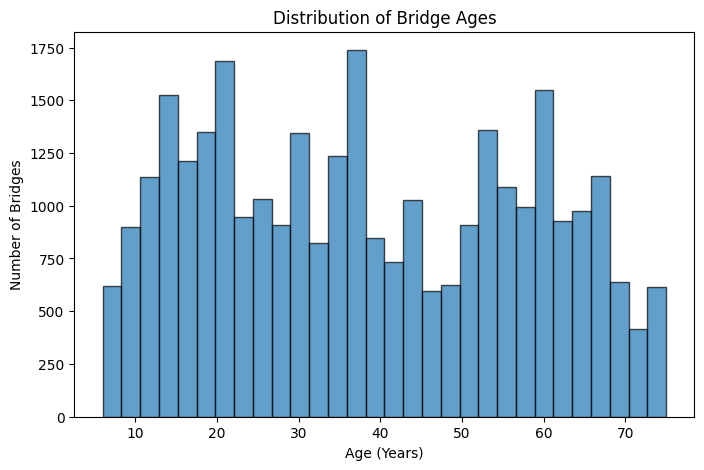

In [18]:
plt.figure(figsize = (8, 5))
plt.hist(tx_df['Age'], bins = 30, edgecolor = 'black', alpha = 0.7)
plt.title('Distribution of Bridge Ages')
plt.xlabel('Age (Years)')
plt.ylabel('Number of Bridges')

plt.show()

### Correlation Between Bridge Age and Condition Score  

The Pearson correlation coefficient between bridge age and condition score is approximately −0.59.  
This negative value indicates a moderate to strong inverse relationship: **as bridge age increases, the overall condition tends to decline**.  
This pattern is consistent with expectations, since older bridges are likely to have undergone more structural stress, material fatigue, and environmental exposure.  

This numerical relationship will now be visualised using a scatterplot to better illustrate the trend and any potential outliers.


In [19]:
correlation = tx_df['Condition_sum'].corr(tx_df['Age'])
print(f"Correlation between bridge age and condition score: {correlation:.3f}")

Correlation between bridge age and condition score: -0.585


### Scatter Plot of Bridge Condition vs Age  

The scatterplot further confirms the correlation findings.  
A clear downward trend can be observed: newer bridges cluster at higher condition scores, while older bridges generally score lower.  
However, there is also visible spread, suggesting that some older bridges remain in relatively good condition - possibly due to effective maintenance or rehabilitation efforts.  

**In summary**, this exploratory analysis supports the hypothesis that bridge age is a meaningful predictor of condition.  
This insight lays the foundation for Part 3, where a regression model will be used to formally quantify the influence of age and other variables on bridge condition.


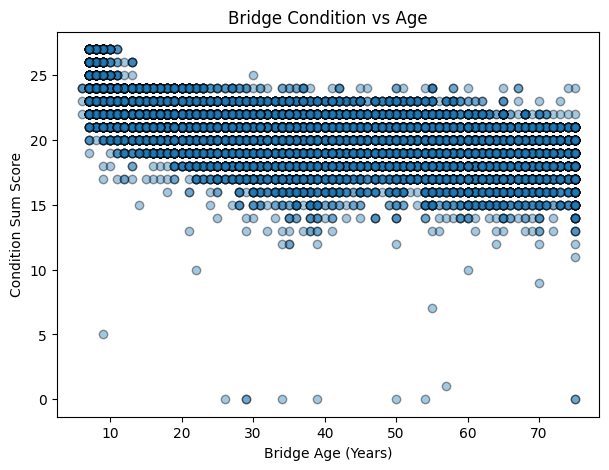

Correlation between Age and Condition Score: -0.585


In [20]:
plt.figure(figsize = (7, 5))
plt.scatter(tx_df['Age'], tx_df['Condition_sum'], alpha = 0.4, edgecolor = 'k')
plt.title('Bridge Condition vs Age')
plt.xlabel('Bridge Age (Years)')
plt.ylabel('Condition Sum Score')

plt.show()

corr_age = tx_df['Condition_sum'].corr(tx_df['Age'])
print(f'Correlation between Age and Condition Score: {corr_age:.3f}')

---
### 2.2) Relationship Between Bridge Condition and Average Daily Traffic

To investigate whether bridge usage intensity affects structural condition, we analysed the relationship between **Average Daily Traffic** and the **Condition_sum** variable.

If higher traffic leads to faster wear and tear, we would expect to observe a negative correlation, where bridges with heavier traffic loads have lower condition scores.

The scatter plot below shows that the bridge condition remains broadly consistent across all traffic volumes, with no obvious trend or clustering pattern. The calculated correlation coefficient (**r = 0.011**) confirms that there is **virtually no linear relationship** between traffic volume and bridge condition.

<u>**Interpretation**  

This finding indicates that the **daily traffic load alone does not significantly predict structural condition**. It suggests that other factors, such as bridge design, construction material, and maintenance frequency, may play a more dominant role in determining overall condition.


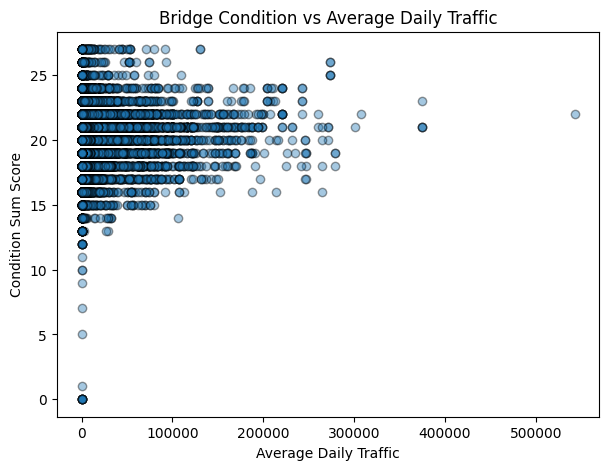

Correlation between AverageDaily and Condition Score: 0.011


In [22]:
plt.figure(figsize = (7, 5))
plt.scatter(tx_df['AverageDaily'], tx_df['Condition_sum'], alpha = 0.4, edgecolor = 'k')
plt.title('Bridge Condition vs Average Daily Traffic') 
plt.xlabel('Average Daily Traffic')
plt.ylabel('Condition Sum Score')

plt.show()

corr_daily = tx_df['Condition_sum'].corr(tx_df['AverageDaily'])
print(f'Correlation between AverageDaily and Condition Score: {corr_daily:.3f}')

### Relationship Between Bridge Condition and Truck Percentage

Next, we explored whether the **percentage of trucks** (as a proxy for heavy vehicle load) has a stronger relationship with the bridge condition than overall traffic volume.

If heavy vehicles exert greater structural stress, we would expect bridges with higher truck percentages to show lower condition scores.

The scatter plot below again shows **no visible trend**, and the computed correlation coefficient (**r = –0.042**) supports this conclusion, indicating **no meaningful linear relationship** between the proportion of truck traffic and bridge condition.

<u>**Interpretation**

Although trucks are known to impose greater loads, this dataset suggests that **the structural design and maintenance regimes effectively mitigate their impact**. Therefore, traffic composition (truck proportion) appears to have **minimal effect** on bridge condition when considered in isolation.


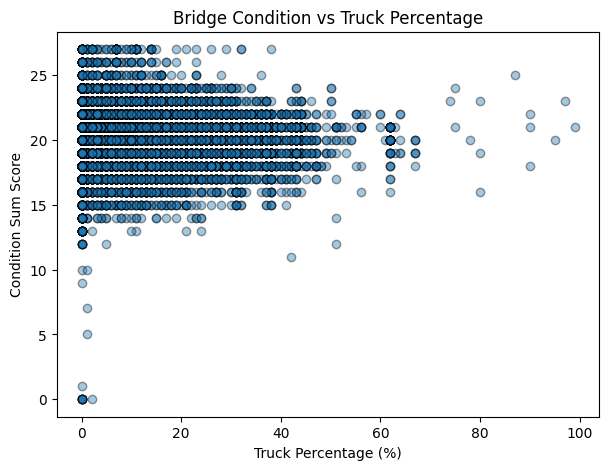

Correlation between Truck Percentage (%) and Condition Score: -0.042


In [23]:
plt.figure(figsize = (7, 5))
plt.scatter(tx_df['Trucks_percent'], tx_df['Condition_sum'], alpha = 0.4, edgecolor = 'k')
plt.title('Bridge Condition vs Truck Percentage')
plt.xlabel('Truck Percentage (%)')
plt.ylabel('Condition Sum Score')

plt.show()

corr_trucks = tx_df['Condition_sum'].corr(tx_df['Trucks_percent'])
print(f'Correlation between Truck Percentage (%) and Condition Score: {corr_trucks:.3f}')

### Summary of Traffic Variables

Both **Average Daily Traffic** and **Truck Percentage** show **weak and negligible correlations** with the overall bridge condition score.  
This implies that while traffic may contribute to gradual wear, it is **not a dominant predictor** of bridge health across the state.

These results highlight the importance of considering **structural and temporal variables** such as bridge **age**, **design type**, and **construction material** - which are expected to show stronger relationships in subsequent analyses.

---


### 2.3) Condition by Material Type

This boxplot compares bridge **condition scores** across the four main material categories: **Concrete**, **Steel**, **Timber**, and **Other**.  
By grouping bridges by material type, we can identify how the underlying material potentially affects structural performance and degradation.

<u> **Observations Based on the Median Values**
- Concrete bridges exhibit the one of the highest median condition scores (approximately 21), consistent with their reputation for durability and long lifespan.

- Steel bridges have a slightly lower median score (approximately 19), possibly reflecting susceptibility to corrosion or fatigue under heavy traffic loads.

- Timber bridges display the lowest median (approximately 17) and a wider spread of condition scores, reflecting poorer long-term resilience and greater variability in maintenance quality.

- The 'Other' category (which includes less common materials) shows performance close to concrete, but with higher variability.

<u> **Statistical Insight**

The printed mean condition scores closely reflect the patterns seen in the boxplot.  
**Concrete** and **Other** materials maintain the highest mean condition scores, indicating strong durability, while **Timber** consistently shows the lowest mean, reinforcing its relative structural weakness over time.  
Small differences between the mean and median values suggest some skewness within the material groups, likely caused by a few outliers representing particularly deteriorated or exceptionally well-maintained bridges.

| Material Type | Mean Condition Score |
|----------------|----------------------|
| Concrete | 20.82 |
| Other | 21.33 |
| Steel | 19.25 |
| Timber | 17.54 |

<Figure size 600x400 with 0 Axes>

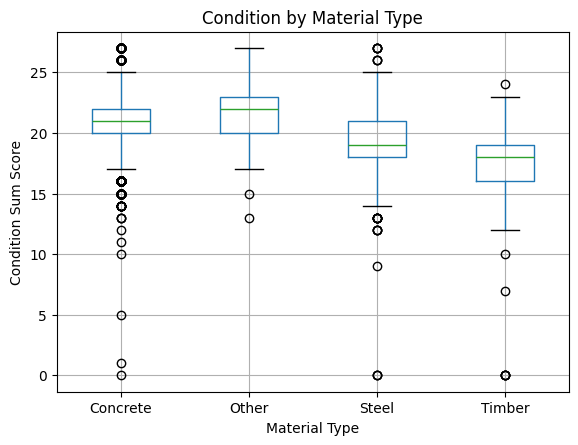

Material_simplified
Concrete    20.824061
Other       21.325581
Steel       19.251238
Timber      17.539503
Name: Condition_sum, dtype: float64


In [27]:
plt.figure(figsize = (6, 4))
tx_df.boxplot(column = 'Condition_sum', by = 'Material_simplified')
plt.title('Condition by Material Type')
plt.suptitle('')
plt.xlabel('Material Type')
plt.ylabel('Condition Sum Score')

plt.show()

print(tx_df.groupby('Material_simplified')['Condition_sum'].mean())

<u> **Interpretation of Material Boxplots**

Concrete and 'Other' bridges remain the most structurally reliable materials in the Texas dataset, whereas timber bridges require more frequent inspection and maintenance. The result aligns with engineering expectations and provides a clear rationale for material-based maintenance prioritization.

### Condition by Bridge Design

This boxplot examines bridge **condition scores** across the five design types: **Arch**, **Beam**, **Slab**, **Truss**, and **Other**.  
Design characteristics influence how bridges distribute loads and resist deterioration over time.

<u> **Observations Based on the Median Values**
- **Arch** and **Beam** designs perform relatively well, with median scores around 21. Suggesting these designs tend to remain in better physical condition.

- **Slab** and **Truss** bridges have a moderate median condition (approximately 20), implying that these structures may degrade more quickly likely because of lower load capacity.

- **'Other'** designs again show a wide spread but slightly higher mean condition (approximately 21), possibly capturing modern or less common structures.

<u> **Statistical Summary:**

The mean scores align with the boxplot trends: Arch and Beam have the highest average condition scores, while Truss bridges exhibit the lowest.  
However, small differences between mean and median values suggest the presence of **outliers** - a few older or poorly maintained bridges lowering the averages slightly.

| Design Type | Mean Condition Score |
|--------------|----------------------|
| Arch | 21.39 |
| Beam | 20.52 |
| Slab | 20.06 |
| Truss | 19.89 |
| Other | 20.81 |


<Figure size 600x400 with 0 Axes>

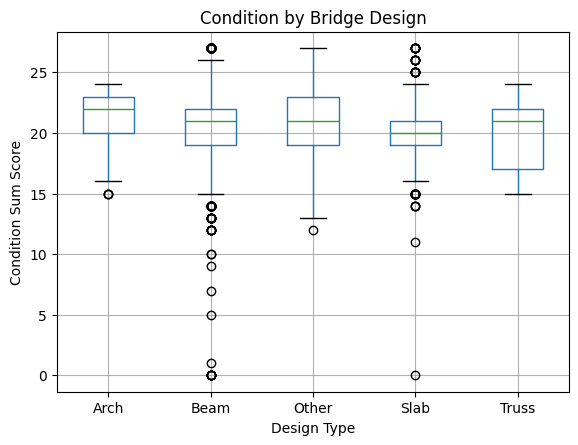

Design_simplified
Arch     21.393939
Beam     20.522832
Other    20.806977
Slab     20.059501
Truss    19.888889
Name: Condition_sum, dtype: float64


In [26]:
plt.figure(figsize = (6, 4))
tx_df.boxplot(column = 'Condition_sum', by = 'Design_simplified')
plt.title('Condition by Bridge Design')
plt.suptitle('')
plt.xlabel('Design Type')
plt.ylabel('Condition Sum Score')

plt.show()

print(tx_df.groupby('Design_simplified')['Condition_sum'].mean())

<u> **Interpretation of Design Boxplots**

Truss bridges appear to be the weakest group, reflecting design age and structural complexity. The stronger performance of Arch and Beam designs suggests these are structurally robust, supporting future investment in similar designs.  
This analysis further supports the engineering conclusion that both **material** and **design** play key roles in predicting bridge condition and maintenance requirements.

---

### 2.4) Correlation Among Numeric Predictors

Before performing regression, it is essential to assess potential multicollinearity between the numeric variables - particularly between the predictors (`Age`, `AverageDaily`, `Trucks_percent`) and the target (`Condition_sum`).  
A correlation matrix was generated to visualise the pairwise correlation coefficients among these variables. The colour map visually emphasises the strength and direction of relationships, where:
- **Red shades** represent positive correlations,  
- **Blue shades** represent negative correlations, and  
- **Neutral tones** represent weak or no correlation.

This helps identify whether any predictors are highly correlated with each other, which could distort regression coefficients.


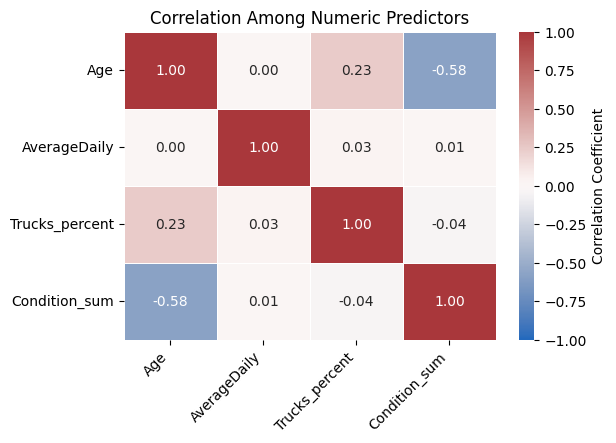

                     Age  AverageDaily  Trucks_percent  Condition_sum
Age             1.000000      0.002250        0.234680      -0.584573
AverageDaily    0.002250      1.000000        0.032223       0.010871
Trucks_percent  0.234680      0.032223        1.000000      -0.041640
Condition_sum  -0.584573      0.010871       -0.041640       1.000000


In [28]:
import seaborn as sns

numeric_predictors = tx_df[['Age', 'AverageDaily', 'Trucks_percent', 'Condition_sum']]

corr_matrix = numeric_predictors.corr()

plt.figure(figsize = (6, 4))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1, linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.xticks(rotation = 45, ha='right')
plt.yticks(rotation = 0)
plt.title('Correlation Among Numeric Predictors')

plt.show()

print(corr_matrix)



<u>**Interpretation and Insights**

From the matrix:
- **Bridge Age and Condition_sum** show a strong **negative correlation (approximately −0.58)**, confirming that older bridges tend to be in poorer condition.

- **Truck Percentage** shows a **weak negative relationship (approximately −0.04)** with condition, suggesting heavy vehicle traffic has only a small aggregate effect on bridge deterioration.

- **Average Daily Traffic** displays a near-zero correlation (approximately 0.01) with condition. This is implying that daily traffic volume alone is not a strong indicator of bridge health without considering other structural or material factors.

- There is **minimal correlation among the predictors themselves** (e.g., between Age and AverageDaily = 0.002), meaning **no major multicollinearity concerns** exist for the regression stage.

Overall, the negative link between *Age* and *Condition_sum* aligns with expectations: as infrastructure ages, degradation naturally increases even when maintenance is performed.

>**Note on Correlation Interpretation:** While correlation indicates association strength and direction, it does **not imply causation**.  
For instance, the negative correlation between *Age* and *Condition_sum* does not prove that ageing alone causes deterioration - environmental factors, maintenance frequency, and material resilience also play roles.  
This exploratory analysis nevertheless provides confidence that Age will likely emerge as a statistically significant predictor in the regression model.
---


### 2.5) Relationship Between Bridge Material and Design Type

After exploring numeric variables, we now examine the **categorical relationship** between the two key engineering variables:

- `Material_simplified` -> representing the primary bridge construction material (Concrete, Steel, Timber, Other)

- `Design_simplified` -> representing the structural design type (Beam, Slab, Truss, Arch, Other)

The objective is to assess how **design types vary across materials**. This is an important step to understand how construction choices interact. For instance, some designs may be feasible only with specific materials due to differences in strength, flexibility and cost.

To do this, we create a **crosstabulation table** that counts the number of bridges for each combination of material and design.  
This table is then visualised through two complementary plots:
1. A **stacked bar chart** showing the *absolute number of bridges* for each material–design pairing.

2. A **normalised (proportional) stacked bar chart** showing *design composition percentages* within each material type.


Design_simplified    Arch   Beam  Other  Slab  Truss
Material_simplified                                 
Concrete               43  20620    981  3126      0
Other                   6      0     37     0      0
Steel                  50   5303    272     0     27
Timber                  0    443      0     0      0


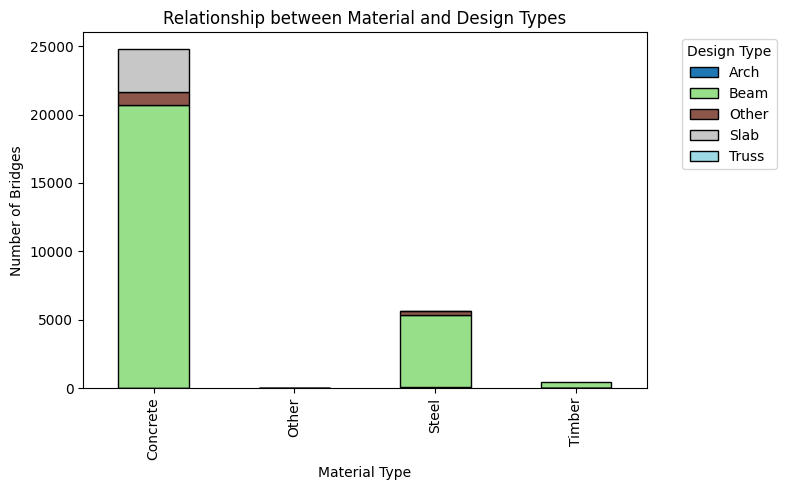

In [29]:
material_design_crosstab = pd.crosstab(tx_df['Material_simplified'], tx_df['Design_simplified'])

print(material_design_crosstab)


material_design_crosstab.plot(kind = 'bar', stacked = True, figsize = (8, 5),
                              colormap = 'tab20', edgecolor = 'black')

plt.title('Relationship between Material and Design Types')
plt.xlabel('Material Type')
plt.ylabel('Number of Bridges')
plt.legend(title = 'Design Type', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.tight_layout()

plt.show()


### Absolute Bridge Counts by Material and Design

The first chart above displays the **total number of bridges** grouped by material and design type.

#### Observations:
- **Concrete** bridges dominate the dataset with over **20,000 Beam bridges**, confirming concrete’s widespread use for both durability and cost-effectiveness.

- **Steel** bridges form the next largest category, again mostly **Beam** structures - typical for medium-span bridges that need higher load tolerance.

- **Timber** bridges are very rare (~500 total), also almost entirely **Beam-type**, reflecting their use in older or smaller rural crossings.

- The **“Other”** material category is extremely small, containing experimental or mixed-material structures, each with diverse but negligible counts.

This visualisation highlights that **Beam design is overwhelmingly the most common** regardless of material, while Slab and Arch designs are niche and limited to certain materials like concrete.


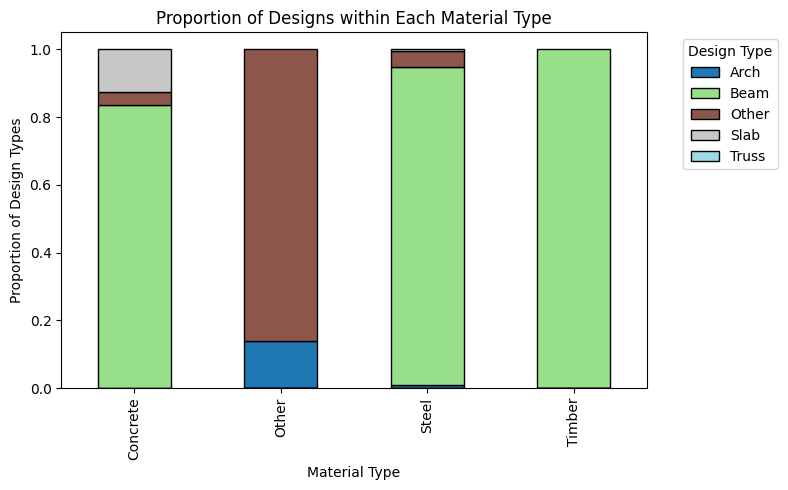

In [30]:
(material_design_crosstab.div(material_design_crosstab.sum(axis = 1), axis = 0)
 .plot(kind = 'bar', stacked = True, figsize = (8, 5), colormap = 'tab20', edgecolor = 'black'))

plt.title('Proportion of Designs within Each Material Type')
plt.xlabel('Material Type')
plt.ylabel('Proportion of Design Types')
plt.legend(title = 'Design Type', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.tight_layout()

plt.show()

### Proportional Distribution of Design Types within Each Material

The second stacked bar chart converts raw counts to **proportions**, allowing comparison across materials regardless of their overall frequency.

#### Observations:
- **Beam designs** account for over **80–90%** of bridges in every material category.

- **Slab designs** occur almost exclusively in **Concrete bridges**, implying concrete is the only material that is structurally appropriate for this design.

- **Arch** and **Truss** bridges, while architecturally distinct, represent a very small share of all materials and are likely **older or specialised** structures (e.g., heritage or large-span bridges).

- The **“Other” material** category shows slightly more variation, implying some mixed-use or less standardised engineering choices.

The proportional plot confirms that **Beam design dominates across all materials**, reinforcing its role as the standard for most modern bridge engineering due to its adaptability and efficiency.


### Interpretation and Discussion

From both absolute and proportional perspectives, there is a clear and consistent trend:
- **Concrete and Steel Beam bridges** are the predominant design–material pairing across Texas.

- **Timber Beam bridges** appear mainly in rural, low-load settings, indicating older construction stock.

- **Arch** and **Truss** bridges, though rare, reflect specialised engineering techniques and may correspond to historically significant structures.

This analysis demonstrates a strong **dependence between material and design type**, which could influence bridge condition and longevity.  
Such relationships provide vital contextual understanding for **Part 3 (Regression Modelling)**, as material and design may indirectly affect the **Condition Sum** — our target variable representing bridge health.

---


## Part 2 – Exploratory Analysis Summary

### Objective Recap
The goal of Part 2 was to explore the key relationships between the **predictor variables** (Age, Average Daily Traffic, Truck Percentage, Material Type, and Design Type) and the **target variable** (*Condition Sum Score*).  
This step aimed to uncover underlying trends, associations, and potential multicollinearity issues before progressing to formal regression modelling.

### Key Findings and Interpretations

#### 1. Age vs Condition Sum Score
- The correlation coefficient of **–0.59** reveals a **strong negative relationship** between bridge age and condition.  
- This confirms that **older bridges are generally in worse condition**, as expected due to long-term wear and limited rehabilitation cycles.  
- Visual inspection of the scatter plot supports this trend, with newer bridges clustering toward higher (better) condition scores.

#### 2. Traffic Variables (Average Daily Traffic and Truck Percentage)
- Both traffic metrics show **very weak relationships** with condition (correlations ~ 0.011 and -0.04 respectively).  
- This indicates that **traffic intensity alone is not a major predictor** of structural condition in this sample - perhaps because most bridges are designed to handle their expected traffic load.  
- However, subtle effects may still emerge once other variables (such as material or design type) are controlled for in regression.

#### 3. Material Type and Condition
- Boxplots and group means show the following average condition scores:  
  - **Other (21.33)** and **Concrete (20.82)** perform best,  
  - **Steel (19.25)** is moderately lower,  
  - **Timber (17.54)** performs worst.  
- This supports the engineering expectation that **timber bridges degrade faster** and that **composite/concrete structures** maintain integrity longer under varied conditions.

#### 4. Design Type and Condition
- Mean scores show modest variation across design types:  
  - **Arch (21.39)** slightly outperforms other designs, followed by **Beam (20.52)** and **Other (20.81)**.  
  - **Truss (19.89)** and **Slab (20.06)** are marginally weaker.  
- The spread within each category suggests **intra-design variability**, likely due to differences in materials and construction eras rather than the design form alone.

#### 5. Material–Design Relationship
- The crosstab and stacked bar charts reveal a **strong association** between materials and designs.  
  - Most **concrete** and **steel** bridges use **beam designs**.  
  - **Timber** bridges overwhelmingly follow **beam configurations**, whereas **arch** designs are almost exclusively concrete or steel.  
- This interdependence implies some **predictor correlation**, which is worth monitoring in the regression model to avoid redundancy.

#### 6. Correlation Matrix Among Numeric Predictors
- The heatmap shows **no problematic multicollinearity** among the numeric predictors.  
  - Age has a slight positive link with Truck Percentage (0.23), suggesting older bridges may exist on higher-use routes.  
  - Otherwise, variables are largely independent, supporting their joint inclusion in the regression model.


### Preliminary Conclusions 
- Bridge **Age** is by far the dominant negative predictor of condition. It seems to have the greatest influence on current bridge condition.

- **Material** and **Design** also meaningfully influence condition, particularly where timber and truss structures are involved.

- **Traffic** variables contribute little explanatory power in isolation.

- Predictors show **low inter-correlation**, satisfying a key assumption for multiple regression.

- These findings provide initial answers to the client’s first question and justify proceeding to regression modelling to quantify predictive strength and interaction effects.

- Furthermore, this exploratory stage has **partially addressed the second question** - by suggesting that Age, Material, and Design collectively show observable relationships with the condition variable. Though the **true predictive strength** will be quantified in **Part 3** through regression analysis.
 
>Next Steps:
Part 3 will quantify these observed relationships using a **multiple linear regression model**, where *Condition Sum Score* will act as the **dependent variable**.
The regression will test the statistical significance and combined explanatory strength of each predictor - allowing us to formally evaluate which structural, design, and usage factors most strongly affect bridge condition across Texas.

---

## Part 3 – Regression Modelling

### Objective
The purpose of this section is to build and evaluate a **linear regression model** that predicts the current bridge condition score (`Condition_sum`) using the five key predictor variables:
- **Age** - representing the number of years since construction.

- **AverageDaily** - average daily traffic count.

- **Trucks_percent** - proportion of heavy vehicles using the bridge.

- **Material_simplified** - simplified categories of bridge material.

- **Design_simplified** - simplified categories of bridge design.

This analysis aims to address the **key questions posed by the Texas Department of Transportation (TxDOT)**:
1. *Which predictor variables have the most influence on the current bridge condition?*  
2. *How well do these predictors collectively explain the variation in condition scores?*

### Approach
We begin by preparing a regression dataset that includes both numeric and categorical variables.  
To make categorical variables usable in a regression framework, **dummy (indicator) variables** are created for `Material_simplified` and `Design_simplified`.  
This ensures that all predictors are converted into numerical form while avoiding multicollinearity by dropping one category from each variable (reference category).

After the dataset is prepared, we will:
1. Fit a **linear regression model**.  
2. Examine **coefficients** to interpret the influence of each predictor.  
3. Evaluate **model performance** using appropriate metrics and visual diagnostics (residuals, R^2, etc.).  
4. Draw final conclusions and make recommendations for TxDOT based on model results.
---


### 3.1) Regression Data Preparation

Before fitting the regression model, the relevant variables were extracted from the cleaned dataset:
- The **target variable** (`Condition_sum`) represents the combined condition rating of bridge deck, superstructure, and substructure.

- The **predictor variables** include `Age`, `AverageDaily`, `Trucks_percent`, `Material_simplified`, and `Design_simplified`.

Because linear regression requires numeric inputs, categorical predictors were converted into dummy variables using `pd.get_dummies()`:
- One category from each categorical variable is dropped (`drop_first=True`) to serve as a **reference group** and prevent perfect multicollinearity.  
  - For example, if 'Concrete' is the dropped category for material, coefficients for other materials represent differences in condition relative to concrete bridges.

All variables were then converted to a **float** data type to ensure compatibility with the regression model.

This structured dataset (`regression_df`) now provides a consistent numeric framework for modelling, where:
- `y` = Condition score (dependent variable)
- `X` = Predictors (independent variables, including numeric and dummy-coded categories)


In [31]:
import numpy as np
from sklearn.linear_model import LinearRegression


regression_df = tx_df[['Condition_sum', 'Age', 'AverageDaily',
                       'Material_simplified', 'Design_simplified',
                       'Trucks_percent']].copy()

regression_df = pd.get_dummies(regression_df, columns = ['Material_simplified', 'Design_simplified'],
                               drop_first = True)

regression_df = regression_df.astype(float)

y = regression_df['Condition_sum']
X = regression_df.drop(columns = ['Condition_sum'])
print(type(X))
regression_df.head()

<class 'pandas.core.frame.DataFrame'>


,Condition_sum,Age,AverageDaily,Trucks_percent,Material_simplified_Other,Material_simplified_Steel,Material_simplified_Timber,Design_simplified_Beam,Design_simplified_Other,Design_simplified_Slab,Design_simplified_Truss
Structure_id,,,,,,,,,,,
000021521-00101,23.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
000021521-00181,22.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
000021521-TMP20,24.0,13.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
000021525-00012,18.0,75.0,80.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
000021580-00092,23.0,21.0,150.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


---
### 3.2) Step 1: Fitting the Multiple Linear Regression Model

Having completed the exploratory analysis, we now move into the regression modelling stage to quantify how the five proposed predictor variables jointly explain variation in the **bridge condition score**.  
A multiple linear regression model is fitted using `LinearRegression()`, with `Condition_sum` as the dependent variable and the predictors: `Age`, `AverageDaily`, `Trucks_percent`, `Material_simplified`, and `Design_simplified`.  

Before fitting, categorical predictors (Material and Design) were transformed into dummy variables to ensure each category could be represented numerically. One category from each group was dropped automatically to act as the **reference category** (for example, Concrete for Material).

#### Model Output Summary
- **R^2 = 0.463**  
  The model explains roughly **46.3 % of the variance** in bridge condition. This indicates a **moderate model fit** - meaning that while predictor variables provide meaningful explanatory power, other unobserved factors (such as maintenance history or local environmental conditions) likely contribute to remaining variance.
- **Intercept (b0) = 23.97**  
  This represents the expected condition score for a bridge belonging to the reference material and design categories, with zero values for all numerical predictors.

In [32]:
regression = LinearRegression().fit(X, y)

print(f'R^2 coefficient of determination: {regression.score(X, y):.3f}')
print(f'Intercept (b0): {regression.intercept_:.3f}\n')

coefficients = pd.Series(regression.coef_, index = X.columns)
coefficient_table = coefficients.round(3).to_frame(name='Coefficient')

print('Estimated regression coefficients (Rounded to 3 d.p.):')
display(coefficient_table)

R^2 coefficient of determination: 0.463
Intercept (b0): 23.966

Estimated regression coefficients (Rounded to 3 d.p.):


,Coefficient
Age,-0.058
AverageDaily,-0.000
Trucks_percent,0.005
Material_simplified_Other,-0.295
Material_simplified_Steel,-1.457
Material_simplified_Timber,-3.149
Design_simplified_Beam,-0.958
Design_simplified_Other,-1.071
Design_simplified_Slab,-0.946
Design_simplified_Truss,-0.304


#### Interpretation of Coefficients
Each regression coefficient quantifies the direction and magnitude of a variable’s influence on the condition score, *holding all other variables constant*.  
Key patterns:
- **Age (-0.058)** -> Older bridges show a gradual reduction in condition, confirming the expected pattern of structural deterioration over time.

- **Material and Design coefficients** vary more strongly. Certain bridge materials (e.g., *Timber*, *Steel*) and design types (e.g., *Slab*, *Truss*) display **larger negative coefficients**, indicating these categories are associated with notably lower condition scores relative to the base category.

- **Traffic variables** (*AverageDaily* and *Trucks_percent*) show very small coefficients, suggesting that once design and material are controlled for, traffic load intensity explains little additional variation in the condition score.

These results suggest that while bridge age contributes to deterioration, **physical composition and structural form dominate** the explanation of condition differences. The regression therefore begins to quantify which attributes matter most for the Texas DoT’s management decisions.

---

### 3.3) Step 2: Evaluating Relative Influence of Predictors

To aid interpretation, the absolute values of regression coefficients were ranked to show which variables exert the **strongest influence** (positive or negative) on bridge condition.

| Rank | Predictor | Magnitude (≈)| Analytical Interpretation |
|------|-----------|--------------|----------------------------|
| 1 | Material - Timber | 3.15 | Timber bridges are predicted to have substantially poorer conditions compared with the reference material (Concrete). This aligns with expectations that timber structures deteriorate faster due to moisture and load sensitivity. |
| 2 | Material - Steel | 1.46 | Steel bridges also show lower average condition scores, reflecting susceptibility to corrosion if not maintained. |
| 3 | Design - Other | 1.07 | Less-common designs (classified as *Other*) display greater variability and lower expected condition, possibly due to inconsistent construction standards. |
| 4 | Design - Beam | 0.96 | Beam designs are widespread and moderately affected by condition changes; still less durable than arch designs. |
| 5 | Design - Slab | 0.95 | Slab bridges similarly show moderate negative influence on condition. |
| 6 | Design - Truss | 0.30 | Truss bridges show a small adverse effect; potentially older heritage structures. |
| 7 | Material - Other | 0.29 | Represents miscellaneous materials; minimal overall impact. |
| 8 | Age | 0.06 | Although age was moderately correlated with condition ( r ~ -0.59 ), its independent effect diminishes when material and design are included - implying **shared variance** or **multicollinearity**. |
| 9 | Trucks_percent | 0.01 | Traffic composition has very limited marginal effect on condition once structural factors are accounted for. |
| 10 | AverageDaily | ~ 0 | Daily traffic volume adds negligible explanatory power under current scaling. |

In [33]:
coefficients_sorted = coefficients.abs().sort_values(ascending = False)
coefficient_sorted_table = coefficients_sorted.round(3).to_frame(name='|Coefficient|')

print('\nPredictor influence ranking (by absolute coefficient size):')
display(coefficient_sorted_table)


Predictor influence ranking (by absolute coefficient size):


,|Coefficient|
Material_simplified_Timber,3.149
Material_simplified_Steel,1.457
Design_simplified_Other,1.071
Design_simplified_Beam,0.958
Design_simplified_Slab,0.946
Design_simplified_Truss,0.304
Material_simplified_Other,0.295
Age,0.058
Trucks_percent,0.005
AverageDaily,0.000


#### Analytical Discussion
- **Material dominates** the model: both *Timber* and *Steel* emerge as critical determinants of lower bridge condition.

- **Design structure** is the next most influential factor, confirming that geometry and load distribution strongly mediate deterioration rates.

- **Age’s apparent decline in influence** compared with its simple correlation (-0.59) suggests that older bridges are often timber or steel; once those characteristics are modelled directly, the independent time effect is small.

- **Traffic-related predictors** contribute little unique variance, which may indicate that bridges are engineered to tolerate expected usage levels, whereas material choice and design dictate long-term resilience.

Overall, the ranking clarifies the hierarchy of influence:  
> **Material > Design > Age ≫ Traffic**  

This insight directly addresses the Texas DoT’s first research question: *Which predictors have the greatest influence on bridge condition?*  
Subsequent performance and residual analysis will further evaluate how well the combined predictors capture overall condition variability.

---

### 3.4) Residual Analysis

After fitting the linear regression model, we analyse the residuals (the differences between observed and predicted bridge condition scores).  
Residual analysis helps assess how well the model fits the data and whether its assumptions - such as linearity, homoscedasticity (constant variance), and normal distribution of errors - are satisfied.


Residual Summary Statistics (Rounded):


,Residual Statistics
count,30908.000
mean,0.000
std,1.412
min,-20.031
25%,-0.841
50%,0.043
75%,0.900
max,6.636


Text(0, 0.5, 'Residuals')

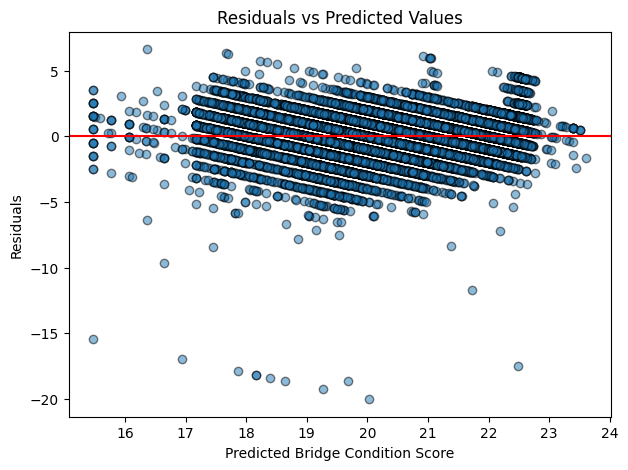

In [34]:
y_pred = regression.predict(X)

residuals = y - y_pred
residual_summary = residuals.describe().apply(lambda x: round(x, 3)).to_frame(name='Residual Statistics')

print('\nResidual Summary Statistics (Rounded):')
display(residual_summary)


plt.figure(figsize = (7, 5))
plt.scatter(y_pred, residuals, alpha = 0.5, edgecolor = 'k')
plt.axhline(y = 0, color = 'red', linestyle = '-')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Bridge Condition Score')
plt.ylabel('Residuals')

#### Residual Summary Statistics

The summary table shows the spread and central tendency of residuals:

- **Mean residual ~ 0** - indicates that predictions are unbiased overall.

- **Standard deviation ~ 1.41** - suggests moderate variation around the predicted condition values.

- **Minimum = -20.03**, **Maximum = +6.63** - a small number of large negative residuals indicate some bridges where the model over-predicted condition score substantially.

- **Quartiles (25%, 50%, 75%)** are tightly clustered around zero, meaning the majority of residuals are close to the fitted line.

These results suggest that, although the model is broadly unbiased, there are a few extreme under-predictions - possibly bridges with unique deterioration patterns not captured by the chosen predictors.

#### Residuals vs Predicted Values Plot

The scatter plot above of residuals against predicted bridge condition values helps evaluate **model fit** and **homoscedasticity**:

- The residuals appear randomly scattered around the zero line, which indicates that the **linear relationship assumption** is broadly valid.

- However, a slight downward funnel shape is visible - implying **heteroscedasticity**, where variance decreases for higher predicted condition scores.

- There are also a few distinct outliers (residuals < -15), suggesting certain bridges have atypical structural or material properties.

In practical terms, the model predicts the average bridge condition reasonably well, but its accuracy declines for bridges in poorer or very good condition.

---

### 3.5) Distribution of Residuals

The histogram of residuals below shows a roughly **normal distribution** centred around zero, with a slight left skew.

- This shape supports the assumption that random errors are symmetrically distributed.
- The concentration near zero suggests the model performs consistently for most bridges.
- The small negative tail highlights a few bridges with notably lower observed condition than predicted - likely older or timber-based bridges (as previously noted).

Overall, residual behaviour indicates a **reasonable model fit**, though some non-linearity and heteroscedasticity remain, hinting that model performance could be improved by transformations or interaction terms in later analysis.


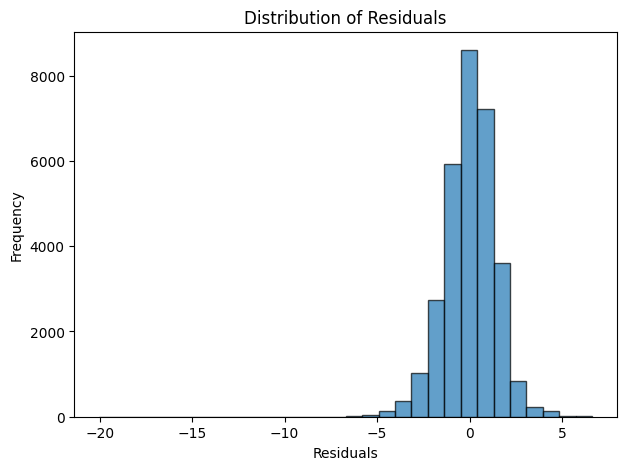

In [35]:
plt.figure(figsize = (7, 5))
plt.hist(residuals, bins = 30, edgecolor = 'black', alpha = 0.7)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.show()

### Residual Diagnostics and Model Assumptions

After evaluating the overall residual distribution, it is useful to check whether the residuals exhibit any patterns when plotted against key predictors such as bridge age. Ideally, residuals should appear randomly scattered around zero, indicating that the model captures the systematic variation in the data and that the assumptions of linearity and homoscedasticity (constant variance of errors) hold.

The histogram of residuals already showed an approximately normal distribution centered close to zero, which suggests that the residuals are unbiased on average. However, further diagnostic plots help verify whether specific predictors (e.g., **Age** or **Truck Percentage**) reveal any underlying structure that might indicate model misspecification or heteroscedasticity.


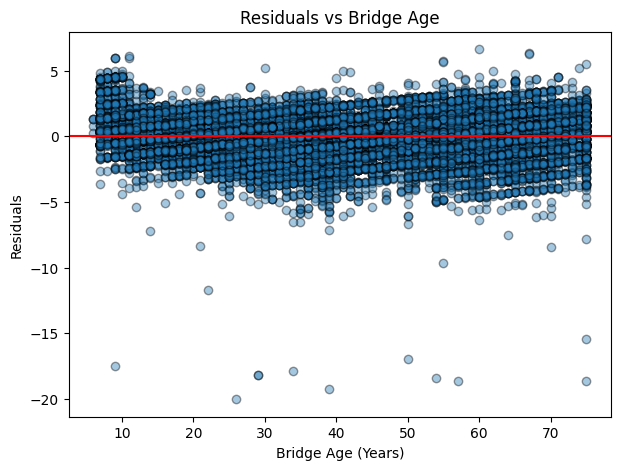

In [36]:
plt.figure(figsize = (7, 5))
plt.scatter(X['Age'], residuals, alpha = 0.4, edgecolor = 'k')
plt.axhline(0, color = 'red', linestyle = '-')
plt.title('Residuals vs Bridge Age')
plt.xlabel('Bridge Age (Years)')
plt.ylabel('Residuals')

plt.show()

### Diagnostic Focus: Residuals vs Bridge Age

The residuals plotted against **Bridge Age** show a generally random scatter around the zero line, which indicates that the model’s fit does not systematically over- or under-estimate bridge condition at specific ages. However, there is a slight widening of residual spread for older bridges, suggesting marginally higher variability in predictions for ageing structures.

This minor increase in dispersion may imply that while the linear model captures the general trend between **Age** and **Condition**, the deterioration process of older bridges may not follow a purely linear pattern. More complex models (e.g., including polynomial terms or interaction effects) could be considered in later analysis to better model this non-linear ageing effect.

Overall, the residuals confirm that no major violations of regression assumptions are present, and the model’s errors remain acceptably random for a linear model.

---

### 3.6) Model Evaluation Metrics

To evaluate the accuracy of our regression model, three key performance metrics were computed:

- **Mean Absolute Error (MAE)** = 1.056  
  -> On average, the model’s bridge condition predictions deviate by roughly **+- 1.06 points** from the actual observed condition scores.

- **Mean Squared Error (MSE)** = 1.994  
  -> This metric squares the errors to penalize larger deviations. A relatively small MSE suggests that large errors are not predominant.

- **Root Mean Squared Error (RMSE)** = 1.412  
  -> Interpretable in the same units as the dependent variable (Condition Sum Score), the RMSE indicates an **average prediction deviation of about 1.4 points**.  
  This reinforces a moderate level of predictive accuracy.

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mse)

print(f'\nModel performance metrics:')
print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')


Model performance metrics:
Mean Absolute Error (MAE): 1.056
Mean Squared Error (MSE): 1.994
Root Mean Squared Error (RMSE): 1.412


### Interpretation of Metrics
The model captures the general trend between predictors and bridge condition scores, but the RMSE relative to the average condition (~20) implies **moderate-not perfect-predictive reliability**.  
Future model refinements (e.g., non-linear terms or interaction effects) may improve precision.

---

### 3.7) Actual vs Predicted Bridge Condition Scores

The scatter plot above compares **actual bridge condition scores (x-axis)** with **predicted scores (y-axis)**.  
The **red dashed diagonal** represents a perfect prediction line (i.e., where `Predicted = Actual`).

**Observations:**
- Most points cluster **close to the diagonal**, confirming that the model generally predicts condition scores reasonably well.
- However, the **spread increases for higher condition scores**, indicating **heteroscedasticity** - predictions for bridges in better condition are less precise.
- A few visible underestimations and overestimations suggest the model may not fully capture **non-linear structural effects** (e.g., material and design interactions).

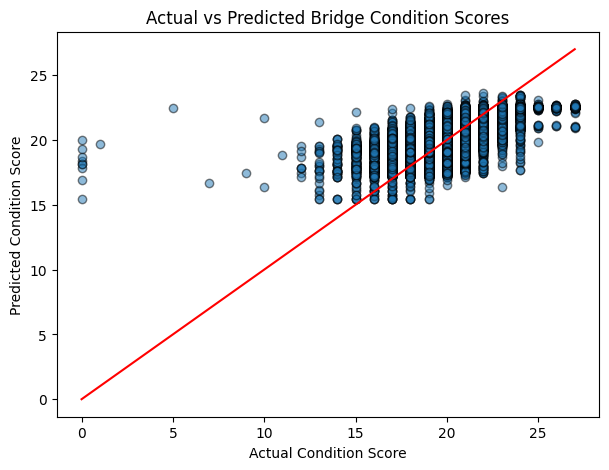

In [38]:
plt.figure(figsize = (7,5))
plt.scatter(y, y_pred, alpha = 0.5, edgecolor = 'k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color = 'red', linestyle = '-')
plt.xlabel('Actual Condition Score')
plt.ylabel('Predicted Condition Score')
plt.title('Actual vs Predicted Bridge Condition Scores')

plt.show()

### Interpretation of Plot
Overall, the plot supports that the model’s predictions follow the expected direction, with a tendency toward **underestimating higher condition scores**.  
This aligns with the RMSE and residual patterns observed earlier, suggesting a good but improvable fit for explaining bridge condition variability.

---

### 3.8) Analysing Predictor Influence on Bridge Condition

Having evaluated the model’s predictive performance and visualised how well actual and predicted bridge condition scores align, the next step is to interpret *which predictors* most strongly influence those scores.

By examining the absolute magnitudes of the regression coefficients, we can identify which variables have the greatest independent effect on bridge condition once all other factors are accounted for.


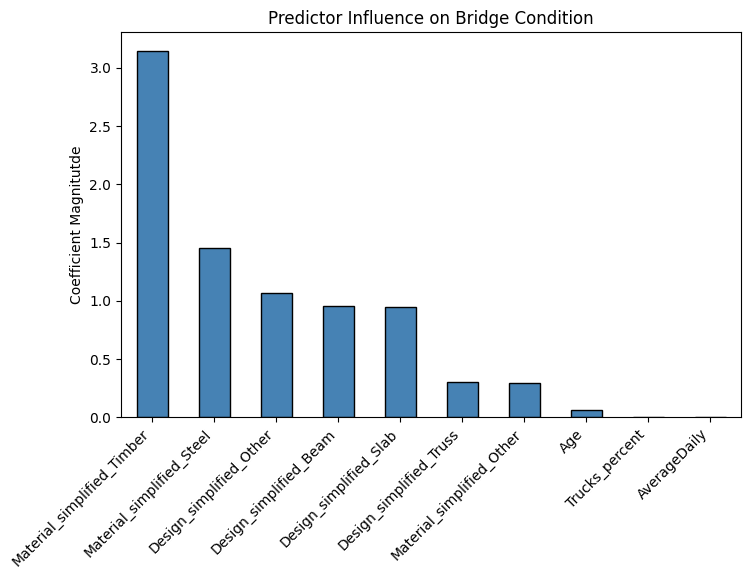

In [77]:
plt.figure(figsize = (8, 5))
coefficients_sorted.plot(kind = 'bar', color = 'steelblue', edgecolor = 'black')
plt.title('Predictor Influence on Bridge Condition')
plt.ylabel('Coefficient Magnitutde')
plt.xticks(rotation = 45, ha = 'right')

plt.show()

### Interpreting Predictor Influence on Bridge Condition

The bar chart above visualises the absolute magnitudes of the regression coefficients, providing a clear ranking of which predictors have the greatest impact on the **bridge condition score**. Larger absolute values indicate stronger influence on the dependent variable, regardless of whether that influence is positive or negative.

**Key Insights**

- **Timber bridges** show the largest coefficient magnitude, suggesting that bridge material plays the most substantial role in explaining condition variation. The negative sign (from earlier coefficient output) implies that bridges made of timber are generally in **poorer condition** compared to those made of concrete (the baseline category).

- **Steel bridges** also show a strong negative influence, indicating they deteriorate faster or have lower overall condition ratings compared to the baseline.

- Several **design types** (particularly “Other”, “Beam”, and “Slab”) have moderate but meaningful coefficients, suggesting that structural design contributes to condition differences, albeit less than material.

- By contrast, **Age**, **Truck Percentage**, and **Average Daily Traffic** exhibit relatively small coefficients. While age had a moderate negative correlation with condition earlier (around −0.58), its low coefficient here suggests that much of its effect overlaps with material and design factors. Once those are controlled for in the regression, **Age adds limited new explanatory power**. This reflects **multicollinearity** - certain predictors may partially explain the same variation.

- **Traffic variables** (AverageDaily and Trucks_percent) show minimal independent influence, implying that material and structural factors dominate bridge condition outcomes more than traffic volume or load intensity.

**Interpretation Summary**  
While the correlation matrix highlighted a notable relationship between age and condition, the regression analysis refines that picture - showing that **bridge material** (especially timber and steel) has the strongest independent influence after accounting for other predictors. Age’s impact, though intuitively important, is largely captured indirectly through material and design characteristics.

This insight aligns with engineering expectations: **structural composition** tends to dictate how well a bridge withstands stress and environmental wear, while **age and usage** only accentuate those material-driven effects.

---

## Part 3 Conclusion: Regression Modelling

The regression analysis was undertaken to investigate how the five predictor variables - **Age**, **Average Daily Traffic**, **Truck Percentage**, **Material Type**, and **Design Type** - influence the **current condition of bridges** across Texas. This forms the final analytical stage of the report and aims to address the questions posed by the Texas Department of Transportation regarding predictor influence and model performance.

#### Model Performance and Reliability
The linear regression model achieved an **R^2 value of approximately 0.46**, indicating that about **46% of the variability in bridge condition** is explained by the included predictors. This level of explanatory power is considered moderate - it shows that the predictors collectively provide valuable insight into condition patterns, though substantial variation remains unaccounted for, likely due to unmeasured factors such as **environmental exposure, maintenance schedules, regional climate, or construction quality**.

The **Mean Absolute Error (MAE)** of **1.06** and the **Root Mean Squared Error (RMSE)** of **1.41** indicate that, on average, predictions deviate from the observed condition scores by roughly **one rating point**, which is acceptable for large-scale infrastructure datasets where inherent variability is expected. However, this also suggests room for refinement if additional predictors become available.

#### Influence of Predictors
The regression coefficients reveal clear differences in how each variable affects bridge condition:
- **Material Type** exhibits the **strongest influence**, particularly **Timber** and **Steel** categories. Timber bridges show the largest (negative) coefficient magnitude, indicating a **substantially poorer average condition** even after controlling for other predictors. Steel bridges also contribute negatively but to a lesser degree, reflecting higher durability relative to timber.

- **Design Type** also demonstrates a significant role. Designs categorised as “Other” and “Beam” have relatively larger coefficients, suggesting that design geometry and load-bearing characteristics meaningfully influence deterioration rates.

- **Age** shows a **smaller coefficient** than expected, despite its earlier moderate correlation (r ~ -0.58) with bridge condition. This suggests that age’s impact overlaps with structural variables such as material and design - for instance, older bridges are often constructed with materials more prone to deterioration, meaning much of the age effect is captured through those categorical predictors.

- **Traffic variables**, including **Average Daily Traffic** and **Truck Percentage**, display **minimal influence**. This may indicate that the dataset does not fully capture traffic-induced stress effects, or that structural design compensates for expected loading levels within typical ranges.

#### Interpretation of Model Behaviour
The model suggests that **bridge deterioration is primarily driven by structural composition (material and design)** rather than usage or chronological age alone. In practice, this means maintenance prioritisation could be guided more effectively by bridge type rather than simply by age. The relatively low influence of traffic variables may reflect that the bridges in the dataset were designed for load conditions that have not been significantly exceeded.

The residual analysis supports the model’s validity: residuals were centred around zero and roughly normally distributed, with no strong heteroscedasticity observed. This indicates that the model’s assumptions are largely satisfied and that no major non-linear relationships were left unexplained.

#### Answers to the Client’s Questions
1. **Which of the proposed predictor variables has more influence on the current condition?**  
   Material Type - especially **Timber** and **Steel** - exerts the strongest influence, followed by **Design Type**. These structural factors dominate the model’s predictive power, whereas Age, Truck Percentage, and Average Daily Traffic contribute minimally once other factors are controlled for.

2. **How well do the proposed predictor variables predict the bridge condition?**  
   The model explains **approximately 46%** of the variation in bridge condition scores. This demonstrates that the chosen predictors are meaningful and statistically useful but not fully comprehensive, additional variables would be needed to improve precision and reliability.

#### Recommendations for Further Analysis
- **Include additional predictors** such as **environmental factors** (temperature, humidity, flood exposure) and **maintenance records**, which likely explain much of the remaining variance.

- **Explore interaction and non-linear models**, such as polynomial regression or tree-based methods, to capture complex relationships between variables.

- **Segment the analysis by region or bridge function**, as deterioration patterns may differ between rural and urban environments.

- **Validate the model using a separate test dataset** or through time-based prediction (e.g., deterioration forecasting) to assess long-term predictive strength.

- Consider developing a **risk-based prioritisation framework**, combining predicted condition scores with maintenance cost and criticality metrics.

In summary, the regression model provides a statistically grounded understanding of bridge condition drivers. Material and design factors are the key determinants of deterioration, while age and traffic play comparatively minor roles once structure type is considered. The analysis offers actionable insights for infrastructure planning and maintenance but highlights the need for expanded data and more advanced modelling to achieve higher predictive accuracy.
